## Unmasking biomacromolecular conformational dynamics from 2D analysis of subdomains vibration modes and molecular kinetics (Tutorial)

### Set up and exploratory analysis

In [49]:
#Importar librerias
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import pandas as pd

Using the library [`MDAnalysis`](https://www.mdanalysis.org/) it can be processed the _topology_ and the _trajectory_ of a simulation. The library has multiple atributes like as `.center_of_mass()`, `.radius_of_gyration()`

In [50]:
fold='../omicron_open_0/'
topology='npt.gro'
trajectory='md_short_compact.xtc'

In [51]:
#Importar archivo .gro y trayectoria .xtc
u = mda.Universe(fold+topology,fold+trajectory)
print(u, f'timesteps: {len(u.trajectory)}')
timesteps=len(u.trajectory)



print(f'{u.atoms.center_of_mass()= }')
print(f'{u.atoms.center_of_geometry()= }')
print(f'{u.atoms.total_mass()= }')
print(f'{u.atoms.radius_of_gyration()= }')
print(f'{len(u.residues)=}')
print(f'Example of residues {u.residues[3]}, {u.residues.atoms=}')

<Universe with 943139 atoms> timesteps: 288
u.atoms.center_of_mass()= array([ 83.33287033, 111.21584664, 124.48687641])
u.atoms.center_of_geometry()= array([ 83.24090162, 110.94599966, 121.83066693])
u.atoms.total_mass()= 5588435.688000007
u.atoms.radius_of_gyration()= 106.2321779681025
len(u.residues)=257942
Example of residues <Residue ASN, 17>, u.residues.atoms=<AtomGroup with 943139 atoms>


We proceed with a preprocessing step where the trajectories from MD are preprocessed to obtain the residues that most affect to the interaction surface between a cutoff distance

In [52]:
def Cont_Res(u,atomgroup1, atomgroup2,cutoff=14):

    n_rbd = len(atomgroup1.residues)  #atomgroup1 protein
    n_ace2 = len(atomgroup2.residues) #atomgroup2 oxygen of the surface
    counter=np.zeros((n_rbd,n_ace2))

    for ts in u.trajectory:
        if ts.frame==0:
            continue
        res_coms1= np.array([r.atoms.center_of_mass() for r in atomgroup1.residues])
        res_coms2= atomgroup2.atoms.positions
        dist_arr2= distances.distance_array(res_coms1, res_coms2, box=u.dimensions)
        mask= (dist_arr2 <cutoff)*1
        counter+=mask#np.tril(mask, -1)

    sum_count=np.sum(counter,axis=1)
    return atomgroup1.residues.resids,sum_count,atomgroup1.residues.resnames#,counter

atomgroup1= u.select_atoms('not(resname SOL or resname DOL or resname NA or resname CL) and prop z<120') #solo proteina
atomgroup2= u.select_atoms('resname DOL and name O1 and prop z > 16') #solo superficie con la parte de oxigenos superior\
hist1,hist2,names=Cont_Res(u,atomgroup1, atomgroup2,cutoff=14)


Having the analysis of the atoms that satisfy the cutoff condition, we obtain the residues that are related to this atoms

In [53]:
prom=0.75
df = pd.DataFrame({'names': names,'# residuo': hist1,'conteo': hist2})
df_g1 = df[df['names'].str.len() == 3]
df_glycan = df[df['names'].str.len() == 4]
prom_min_g1 = (df_g1['conteo'].max())*prom
prom_min_glycan = (df_glycan['conteo'].max())*prom
df_g1_filtered = df_g1[df_g1['conteo'] >= prom_min_g1]
df_glycan_filtered = df_glycan[df_glycan['conteo'] >= prom_min_glycan]

str_g1 = ' '.join(df_g1_filtered['# residuo'].astype(str)) # Convert column residue to string and concatenate values
str_glycan = ' '.join(df_glycan_filtered['# residuo'].astype(str)) # Convert column residue to string and concatenate values
selection_protein = 'resid '+str_g1
selection_glycan = 'resid '+str_glycan

#check selection
print(selection_protein)
print(selection_glycan)

resid 476 477 478 479 486 487 444 445 446 447 481 482 483 484 486
resid 2 8 9 7 2 3 4 5 6 7 8 9 10 11 8


For the multiple domain analysis, in this example we choose residues for the SARS-CoV-2 spike simulation

In [54]:
#Select domain
domain_group1 = u.select_atoms(selection_protein) #resid residue-number-range (inclusive)
domain_glycan = u.select_atoms(selection_glycan)
domain = domain_glycan #single domain
# domain = domain_glycan+domain_group1+domain_group2 #multiple domain
print(f'{u.trajectory=}\nAtoms in domain selected: {len(domain_group1.atoms)+len(domain_glycan.atoms)}')

u.trajectory=<XTCReader ../omicron_open_0/md_short_compact.xtc with 288 frames of 943139 atoms>
Atoms in domain selected: 10510



In this step, the data is reordered by the following structure

$$
\mathbf{X} = \begin{pmatrix}
| & | & \cdots & | & |  \\
\mathbf{x^{(1)}} & \mathbf{x^{(2)}}  & \cdots & \mathbf{x^{(n-2)}} & \mathbf{x^{(n-1)}}  \\
| & | & \cdots & | & |
\end{pmatrix}
$$

Where $\mathbf{x}^{(1)}$ correspond to the initial time of the trajectory where all the coordinates are reordered in the column vector

In [55]:
#Create trajectory matrix
nt = timesteps
X1 = np.zeros((len(domain)*3,nt)) #Trajectory matrix
for nt_step in u.trajectory:
    X1[:,nt_step.frame] = np.reshape(domain_glycan.positions,-1) # [x1,y1,z1,x2,y2,z2,...] can be improved!
[U,S,Vh] = np.linalg.svd(X1,full_matrices=False) #svd 

A preliminary tool is the Principal Component Analysis (PCA)

PCA is a dimensionality reduction machine learning method that can give a r-dimensional space where most of the variance of the trajectory is retained. The method can be formulated by different ways, a example is with the SVD decomposition for the matrix $\mathbf{X}$
$$
\mathbf{X} = U\Sigma V^{T}
$$
The columns of $U$ gives the principal components ordered decreasingly by variance, $\Sigma$ describe how important is a given principal component to the global variance of the trajectory, with that we analyse how many $r$ PC we have to retain to keep _most_ of the variance of the trajectory, and what are the PC that describes a low-dimensional space of the trajectory.

The PC are orthonormal, so the following identity is satisfied
$$
U^{T}U = UU^{T} = I
$$

First 10 singular values scaled: [69.53746417  3.41348414  1.55313305  0.92337288  0.8371596   0.64567267
  0.60819649  0.50697028  0.43225255  0.40001832]
sum of variance 10 values 78.86
Orthonormality check (for U) 1.0000


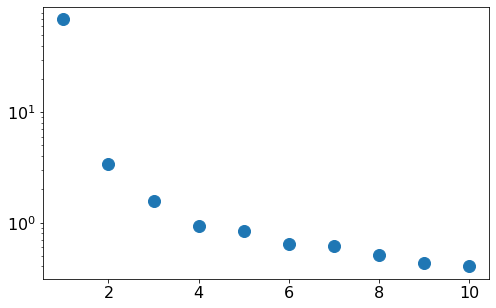

In [56]:
r=10 #number of Principal components (or spatial modes) retained

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 16
plt.figure(figsize=(8,5))
S_scaled = 100*S/np.sum(S)
plt.plot(np.linspace(1,r,r),S_scaled[:r],'o',markersize=12)
plt.yscale('log')
print(f'First {r} singular values scaled: {S_scaled[:r]}')
print(f'sum of variance {r} values {np.sum(S_scaled[:r]):.2f}')
print(f'Orthonormality check (for U) {np.linalg.det(U[:,:r].T@U[:,:r]):.4f}')

To get a grasp of the data we can see two PC plotted in a scatter plot, where it can be identified the most density state on the trajectory for example

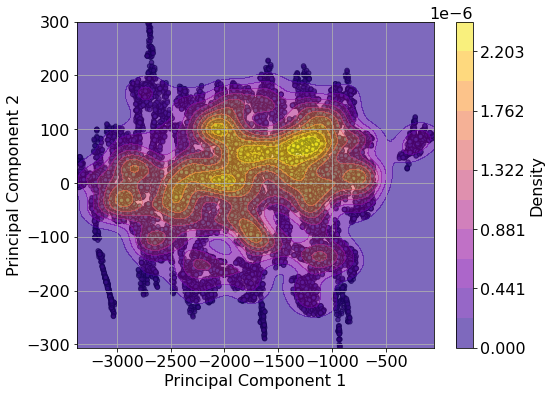

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example data: First two principal components
PC1 = S[0] * U[:, 0]
PC2 = S[1] * U[:, 1]

# Perform kernel density estimation
xy = np.vstack([PC1, PC2])  # Stack PC1 and PC2
kde = gaussian_kde(xy)      # Kernel Density Estimation

# Define a grid for contour plotting
x_grid, y_grid = np.meshgrid(
    np.linspace(PC1.min(), PC1.max(), 100),
    np.linspace(PC2.min(), PC2.max(), 100)
)
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(grid_coords).reshape(x_grid.shape) #/np.sum(density.reshape(-1))

# Plot the scatter with filled density contours
plt.figure(figsize=(8, 6))
plt.scatter(PC1, PC2, c=kde(xy), cmap='viridis', alpha=0.7, edgecolor='k', s=20)
# Add filled contours
contour_levels = np.linspace(density.min(), density.max(), 12)  # Adjust levels for detail
plt.contourf(x_grid, y_grid, density, levels=contour_levels, cmap='plasma', alpha=0.6)

# Add color bar and labels
cbar = plt.colorbar()
cbar.set_label('Density')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


To apply Dynamic Mode Decomposition (DMD) [(Schmid 2010](https://doi.org/10.1017/S0022112010001217)[; Tu et al. 2014;](doi.org/10.3934/jcd.2014.1.391)[ Williams et al. 2015)](doi.org/10.1007/s00332-015-9258-5) to the trajectory data, the data is reordered with the follow structure
$$
\mathbf{X} = \begin{pmatrix}
| & | & \cdots & | & |  \\
\mathbf{x^{(1)}} & \mathbf{x^{(2)}}  & \cdots & \mathbf{x^{(n-2)}} & \mathbf{x^{(n-1)}}  \\
| & | & \cdots & | & |
\end{pmatrix}
$$

$$
\mathbf{X'} = \begin{pmatrix}
| & | & \cdots & | & |  \\
\mathbf{x^{(2)}} & \mathbf{x^{(3)}}  & \cdots & \mathbf{x^{(n-1)}} & \mathbf{x^{(n)}}  \\
| & | & \cdots & | & |
\end{pmatrix}
$$

Where $\mathbf{x}^(j)$ correspond to the $j$ instant in time where all the coordinates of the atoms are stacked in the vector array. The assumption is that the data follows the relation

$$
\mathbf{X'} = A\mathbf{X}
$$

The method search the matrix $A$ that fits the model better. There are many different extensions of the DMD model, that can be find in the papers above. In practice, the state is predicted using the dynamical modes $\mathbf{\Phi}$ and the eigenvalues $\mathbf{\Lambda}$ that comes from the matrix $A$ and a $\mathbf{b_0}$ constant is fitted given a initial condition. The prediction for the trajectories at time $k$
$$
\hat{\mathbf{X}^{k}} = \mathbf{\Phi}\mathbf{\Lambda}^{k}\mathbf{b_0}
$$

In the following sections, we will explore the main ideas of DMD applications for the trajectory

### DMD: Full trajectories (Single domain)

In [58]:
#Importar librerias
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from matplotlib import rcParams
from MDAnalysis.analysis import rms, align

As previosly explained, we apply DMD on the trajectory data of the simulation we rely on the library [`PyDMD`](https://github.com/PyDMD/PyDMD) ([Demo et al. 2018](https://joss.theoj.org/papers/10.21105/joss.00530)[Ichinaga et al. 2024](https://arxiv.org/abs/2402.07463)). We rearrange the trajectory data to the format explained as a input to the `PyDMD` library

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\pydmd\bopdmd.py:812: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


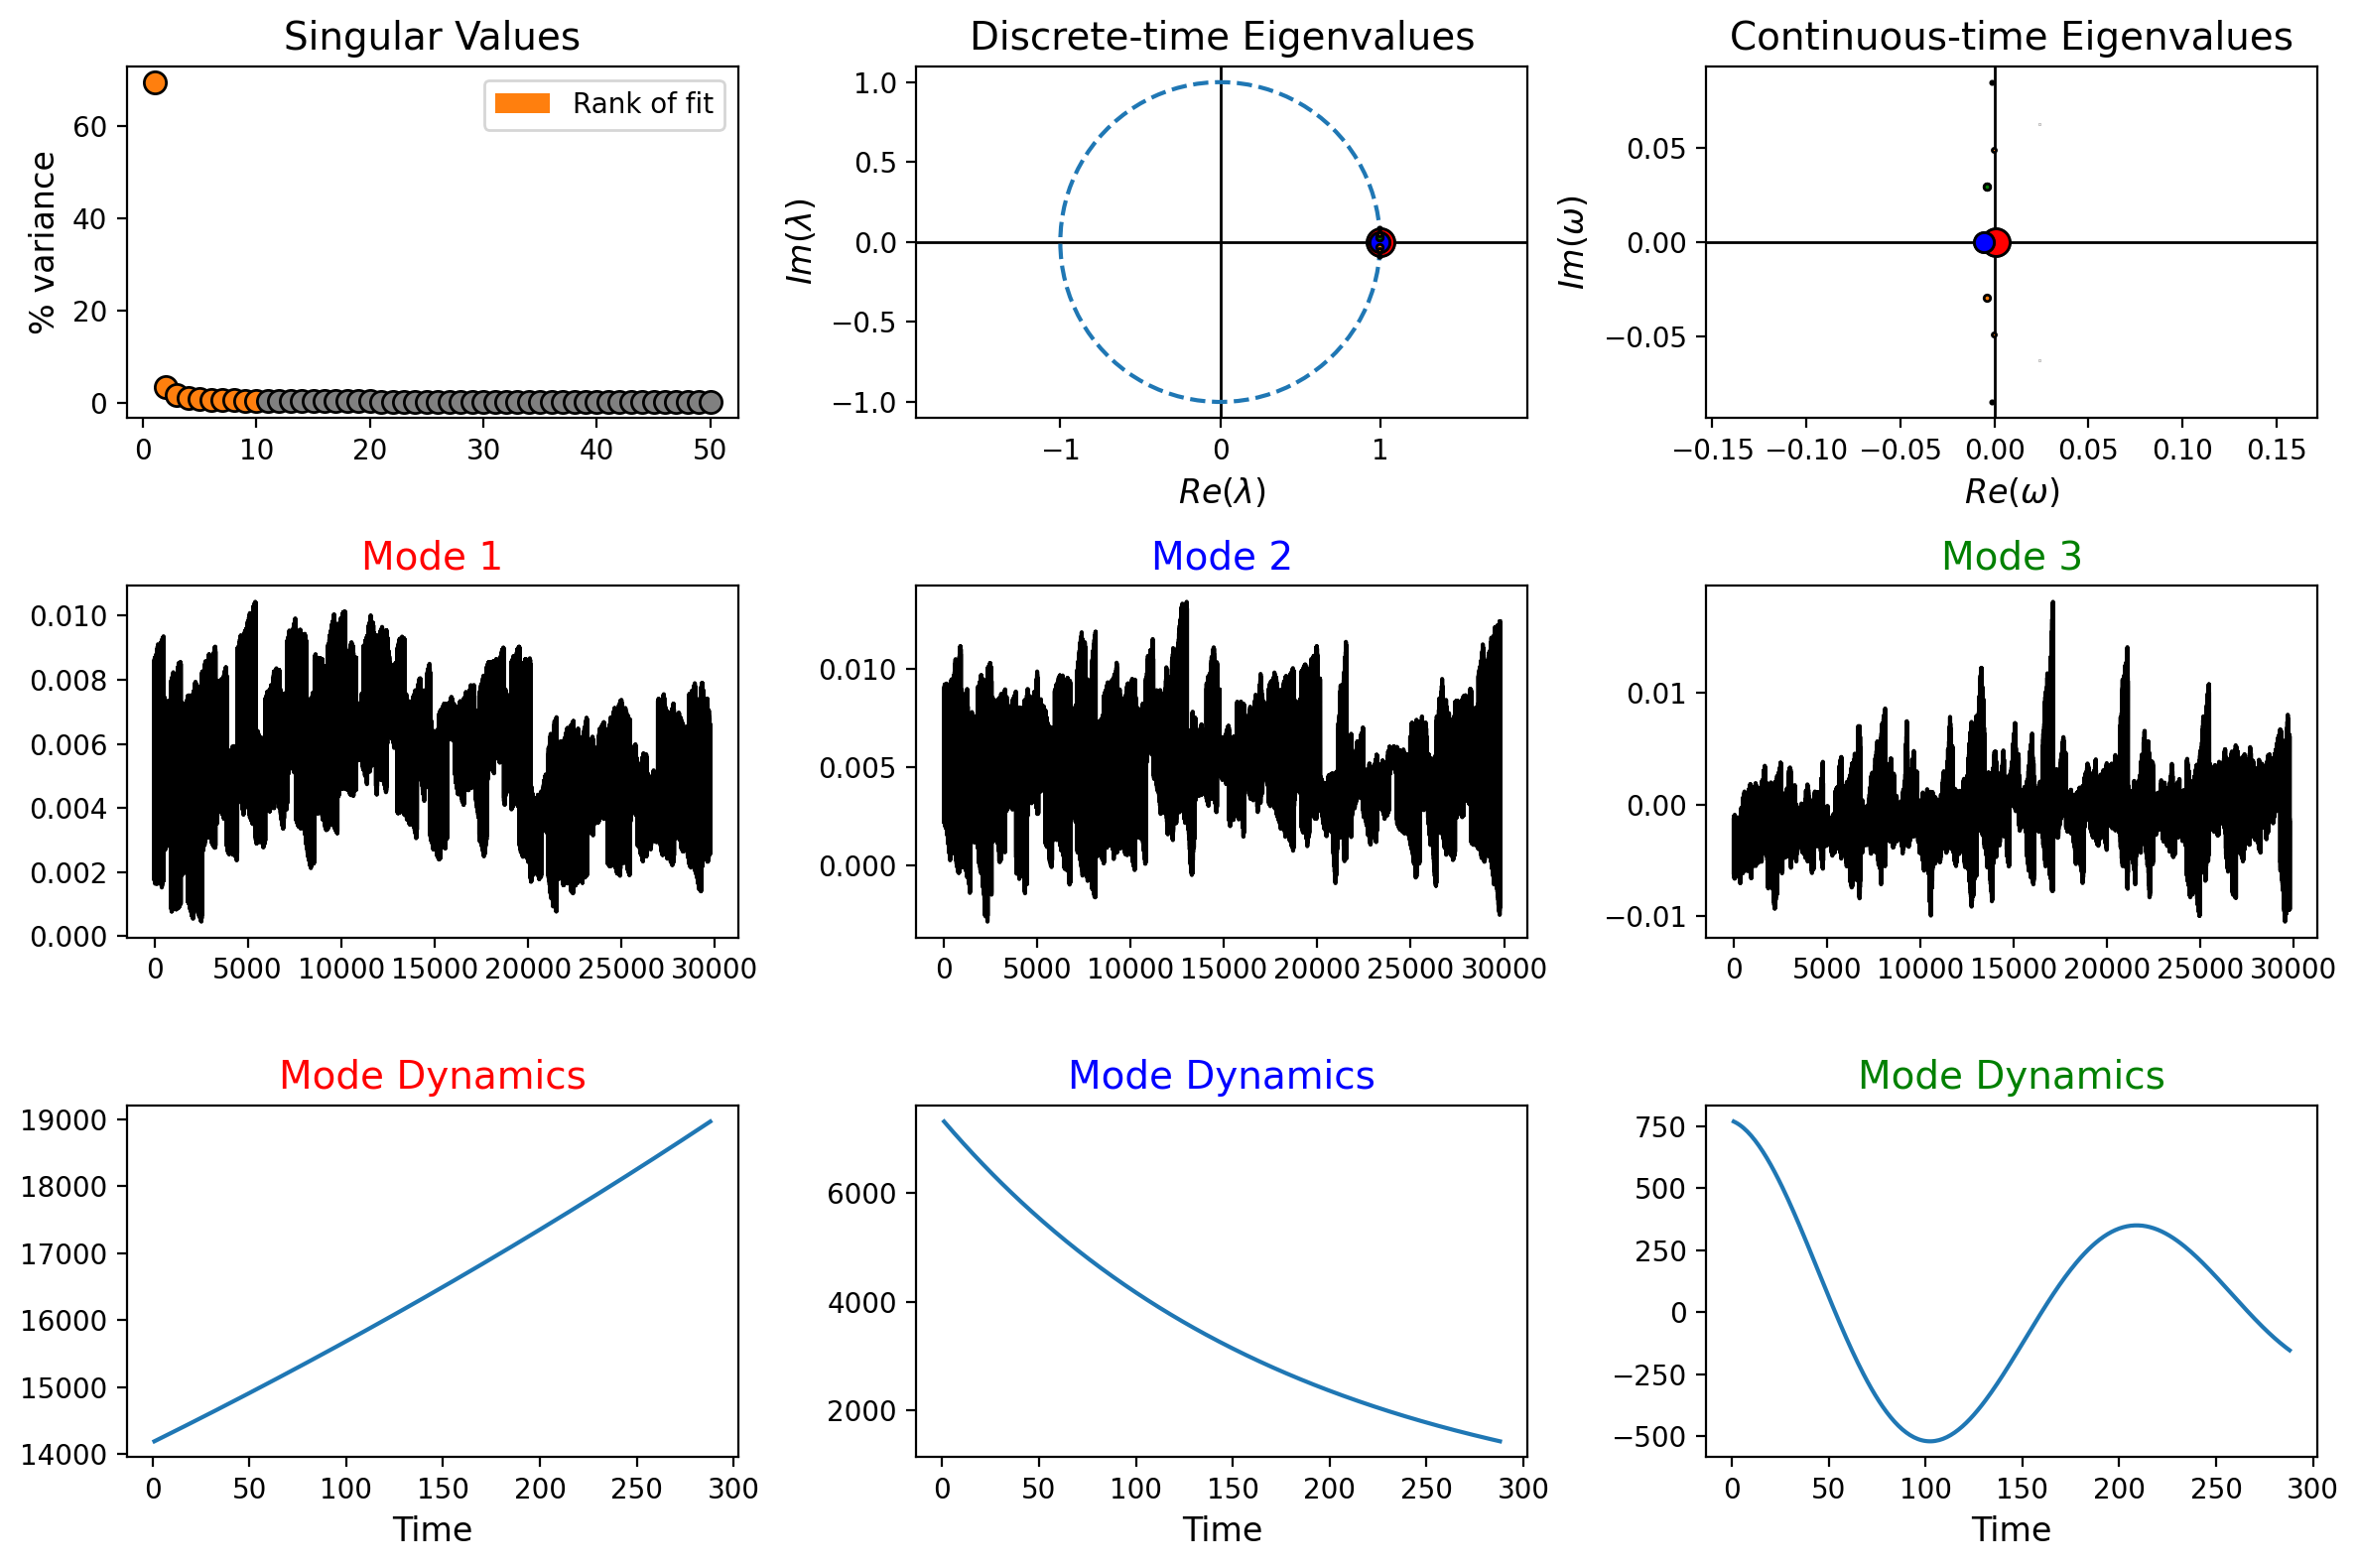

In [59]:
u = mda.Universe(fold+topology,fold+trajectory)
#Select domain
domain_group1 = u.select_atoms(selection_protein) #resid residue-number-range (inclusive)
domain_glycan = u.select_atoms(selection_glycan)
#Create trajectory matrix
domain=domain_glycan
nt = timesteps
r=10 #number of modes retained
X1 = np.zeros((len(domain)*3,nt)) #Trajectory matrix
for nt_step in u.trajectory:
    X1[:,nt_step.frame] = np.reshape(domain.positions,-1) # [x1,y1,z1,x2,y2,z2,...] can be improved!

from pydmd import DMD, BOPDMD, EDMD
from pydmd.plotter import plot_eigs, plot_summary
%matplotlib inline

# Build the Optimized DMD model.
t = np.linspace(1,nt,nt)
optdmd = BOPDMD(svd_rank=r)#, varpro_opts_dict={"verbose": True, "tol": 0.04}) #uncomment to add options
optdmd.fit(X1, t)
# Plot a summary of the DMD results.
plot_summary(optdmd)

In comparison to deep learning methods, the results here are interpretable. Specifically, Mode 1 refers to a spatial mode, following the format of the trajectory matrix: $(x_1, y_1, z_1, x_2, y_2, z_2, \dots, x_n, y_n, z_n)$. The mode dynamics are related to the eigenvalues obtained. Simply put, the real part of the eigenvalue indicates the growth of the mode over time, while the imaginary part describes the _oscillations_ of the mode in the dynamics.

In [60]:
domain.atoms.write(fold+'domain_DMD.gro') #write gro from domain

#create .xtc for dmd reconstructed trajectory
n_atoms = len(domain)
# Reshape X1 to [n_timesteps, n_atoms, 3]
X1_reshaped = np.real(optdmd.reconstructed_data).T.reshape(nt, n_atoms, 3)  # Transpose and reshape
with mda.coordinates.XTC.XTCWriter(fold+'md_nowater_noPBL_DMD.xtc', n_atoms=n_atoms) as writer:
    for idx,frame in enumerate(X1_reshaped):
        domain.positions = frame  # Update positions for the atoms in the selection
        writer.write(domain)  # Write the frame (positions and time) to the trajectory

with mda.coordinates.XTC.XTCWriter(fold+'md_nowater_noPBL_DMD_ref.xtc', n_atoms=n_atoms) as writer:
    for idx,frame in enumerate(X1_reshaped):
        domain.positions = frame # Update positions for the atoms in the selection
        writer.write(domain)  # Write the frame (positions and time) to the trajectory
        break


We can reconstruct statistics from MD simulation with the DMD reconstructions and make comparison with the original MD simulation

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\MDAnalysis\analysis\rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


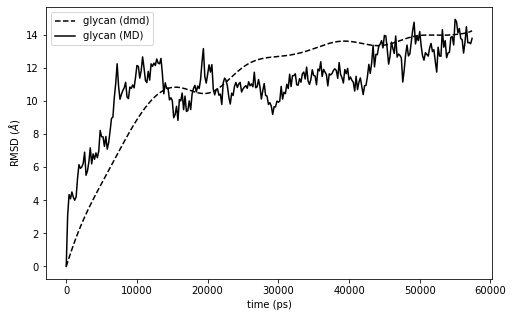

In [61]:
u_dmd = mda.Universe(fold+'domain_DMD.gro',fold+'md_nowater_noPBL_DMD.xtc')
u_dmd_ref = mda.Universe(fold+'domain_DMD.gro',fold+'md_nowater_noPBL_DMD_ref.xtc')

#Create plot RMSD DMD
aligner = align.AlignTraj(u_dmd, u_dmd_ref, select=selection_glycan, in_memory=True)
aligner.run()
R = mda.analysis.rms.RMSD(u_dmd, u_dmd_ref)              
R.run()
rmsd_dmd = R.rmsd.T   
#Create plot RMSD original
aligner = align.AlignTraj(u, u, select=selection_glycan, in_memory=True)
aligner.run()
R = mda.analysis.rms.RMSD(u, u, groupselections=[selection_glycan,       # GROUP1 idx3
                                              selection_protein], ref_frame=0)     # glycan idx5 con el cambio ahora idx4
R.run()
rmsd = R.rmsd.T   # transpose makes it easier for plotting

#print(rmsd)

#Plot
fig = plt.figure(figsize=(8,5))
plt.plot(rmsd[0]*u.coord.dt, rmsd_dmd[2], 'k--',  label="glycan (dmd)"); 
plt.plot(rmsd[1], rmsd[4], 'k',  label="glycan (MD)");  #aqui cambie el 5 por 4 ya que quitamos el grupo2
plt.legend(loc="best"); plt.xlabel("time (ps)"); plt.ylabel(r"RMSD ($\AA$)");

Text(0.5, 0.98, 'Timestep 0.0')

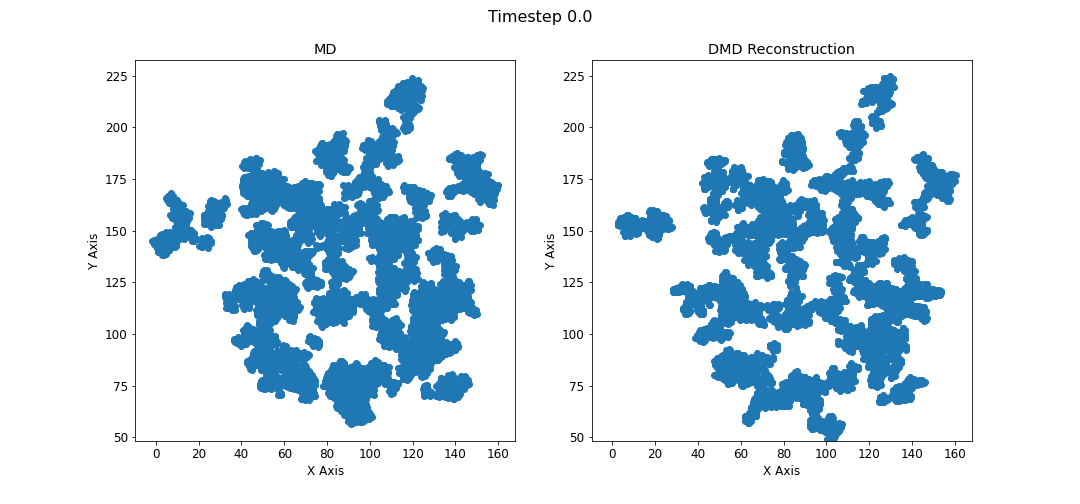

In [62]:
timestep = 0
X_traj_dmd = optdmd.reconstructed_data.reshape(len(domain_glycan),3,nt)
X_traj = X1.reshape(len(domain_glycan),3,nt) 
%matplotlib widget

rcParams['font.size'] = 12
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))
ax1.scatter(np.real(X_traj[:,0,timestep]),np.real(X_traj[:,1,timestep]))
ax1.set_title('MD'); ax1.set_xlabel('X Axis'); ax1.set_ylabel('Y Axis')

ax2.scatter(np.real(X_traj_dmd[:,0,timestep]),np.real(X_traj_dmd[:,1,timestep]))
ax2.set_title('DMD Reconstruction'); ax2.set_xlabel('X Axis'); ax2.set_ylabel('Y Axis')
ax2.set_xlim(ax1.get_xlim()); ax2.set_ylim(ax1.get_ylim())

fig.suptitle(f'Timestep {rmsd[0,timestep]}', fontsize=16)

#### Create animation (optional)

In [63]:
X_traj = X1.reshape(len(domain_glycan),3,nt) #(n_atoms, axis, nt)
X_traj_dmd = optdmd.reconstructed_data.reshape(len(domain_glycan),3,nt)
timestep = 20
import matplotlib.pyplot as plt
import os
%matplotlib widget

x_min = min(X_traj[:, 0, :].min(), X_traj_dmd[:, 0, :].real.min()) - 5
x_max = max(X_traj[:, 0, :].max(), X_traj_dmd[:, 0, :].real.max()) + 5
y_min = min(X_traj[:, 1, :].min(), X_traj_dmd[:, 1, :].real.min()) - 5
y_max = max(X_traj[:, 1, :].max(), X_traj_dmd[:, 1, :].real.max()) + 5
z_min = min(X_traj[:, 2, :].min(), X_traj_dmd[:, 2, :].real.min()) - 5
z_max = max(X_traj[:, 2, :].max(), X_traj_dmd[:, 2, :].real.max()) + 5

for j in range(0, nt, timestep):
    fig = plt.figure(figsize=plt.figaspect(1)*1.5)
    ax = fig.add_subplot(projection='3d', proj_type='ortho')
    ax.scatter(X_traj[:, 0, j], X_traj[:, 1, j], X_traj[:, 2, j])
    ax.set_xlabel('X Axis'); ax.set_ylabel('Y Axis'); ax.set_zlabel('Z Axis')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])
    ax.view_init(elev=27, azim=-43)
    ax.set_title("Original", fontsize=18, pad=20)
    if not os.path.exists(fold+'original'):
        os.mkdir(fold+'original')
    plt.savefig(fold+f'original/plot_{j:05d}.png')
    plt.close()


for j in range(0, nt, timestep):
    fig = plt.figure(figsize=plt.figaspect(1)*1.5)
    ax = fig.add_subplot(projection='3d', proj_type='ortho')
    ax.scatter(np.real(X_traj_dmd[:, 0, j]), np.real(X_traj_dmd[:, 1, j]), np.real(X_traj_dmd[:, 2, j]))
    ax.set_xlabel('X Axis'); ax.set_ylabel('Y Axis'); ax.set_zlabel('Z Axis')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])
    ax.view_init(elev=27, azim=-43)
    ax.set_title("DMD", fontsize=18, pad=20)
    if not os.path.exists(fold+'dmd'):
        os.mkdir(fold+'dmd')
    plt.savefig(fold+f'dmd/plot_{j:05d}.png')
    plt.close()
    




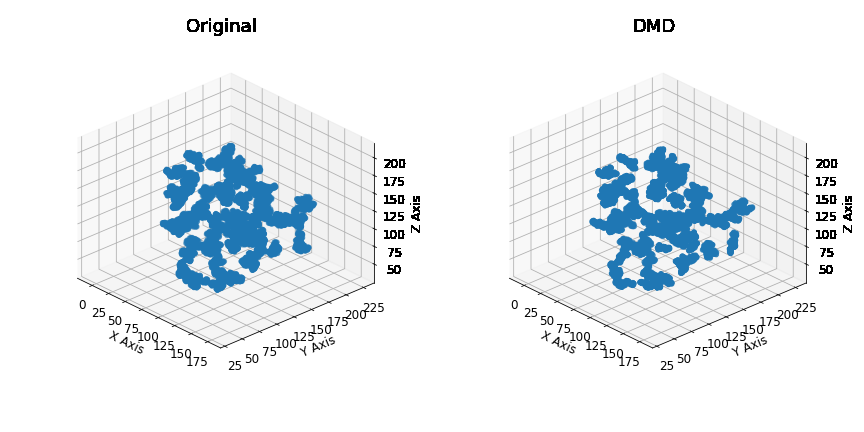

In [65]:
# Generate a GIF
from PIL import Image, ImageDraw, ImageFont
import glob
from IPython.display import Image as IPImage, display

original_folder = fold + 'original/'
dmd_folder = fold + 'dmd/'

combined_folder = fold + 'combined/'
if not os.path.exists(combined_folder):
    os.mkdir(combined_folder)

combined_images = []

# combine imgs
for file in sorted(glob.glob(original_folder + "*.png")):
    index = os.path.basename(file).split('_')[1].split('.')[0]
    original_image = Image.open(file)
    dmd_image = Image.open(dmd_folder + f"plot_{index}.png")

    width, height = original_image.size
    dmd_image = dmd_image.resize((width, height))

    combined_width = width * 2
    combined_height = height 
    combined_image = Image.new("RGB", (combined_width, combined_height), "white")

    combined_image.paste(original_image, (0, 0))
    combined_image.paste(dmd_image, (width, 0))
    combined_image_path = combined_folder + f"combined_{index}.png"
    combined_image.save(combined_image_path)
    combined_images.append(combined_image_path)

# Crear GIF
gif_path = fold + "comparison.gif"
images = [Image.open(img) for img in combined_images]
images[0].save(
    gif_path,
    save_all=True,
    append_images=images[1:],
    optimize=False,
    duration=250,  
    loop=0,  # 0 para bucle infinito y 1 to stop
)

display(IPImage(filename=gif_path))


### DMD: Full trajectories (Multiple domains)

In [66]:
#Importar librerias
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from matplotlib import rcParams
from MDAnalysis.analysis import rms, align
from MDAnalysis.analysis.rms import RMSF

As previosly explained, we apply DMD on the trajectory data of the simulation we rely on the library [`PyDMD`](https://github.com/PyDMD/PyDMD) ([Demo et al. 2018](https://joss.theoj.org/papers/10.21105/joss.00530)[Ichinaga et al. 2024](https://arxiv.org/abs/2402.07463)). We rearrange the trajectory data to the format explained as a input to the `PyDMD` library

Here we focus in GROUP1, GROUP2 and glycan of the simulation

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\pydmd\bopdmd.py:812: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


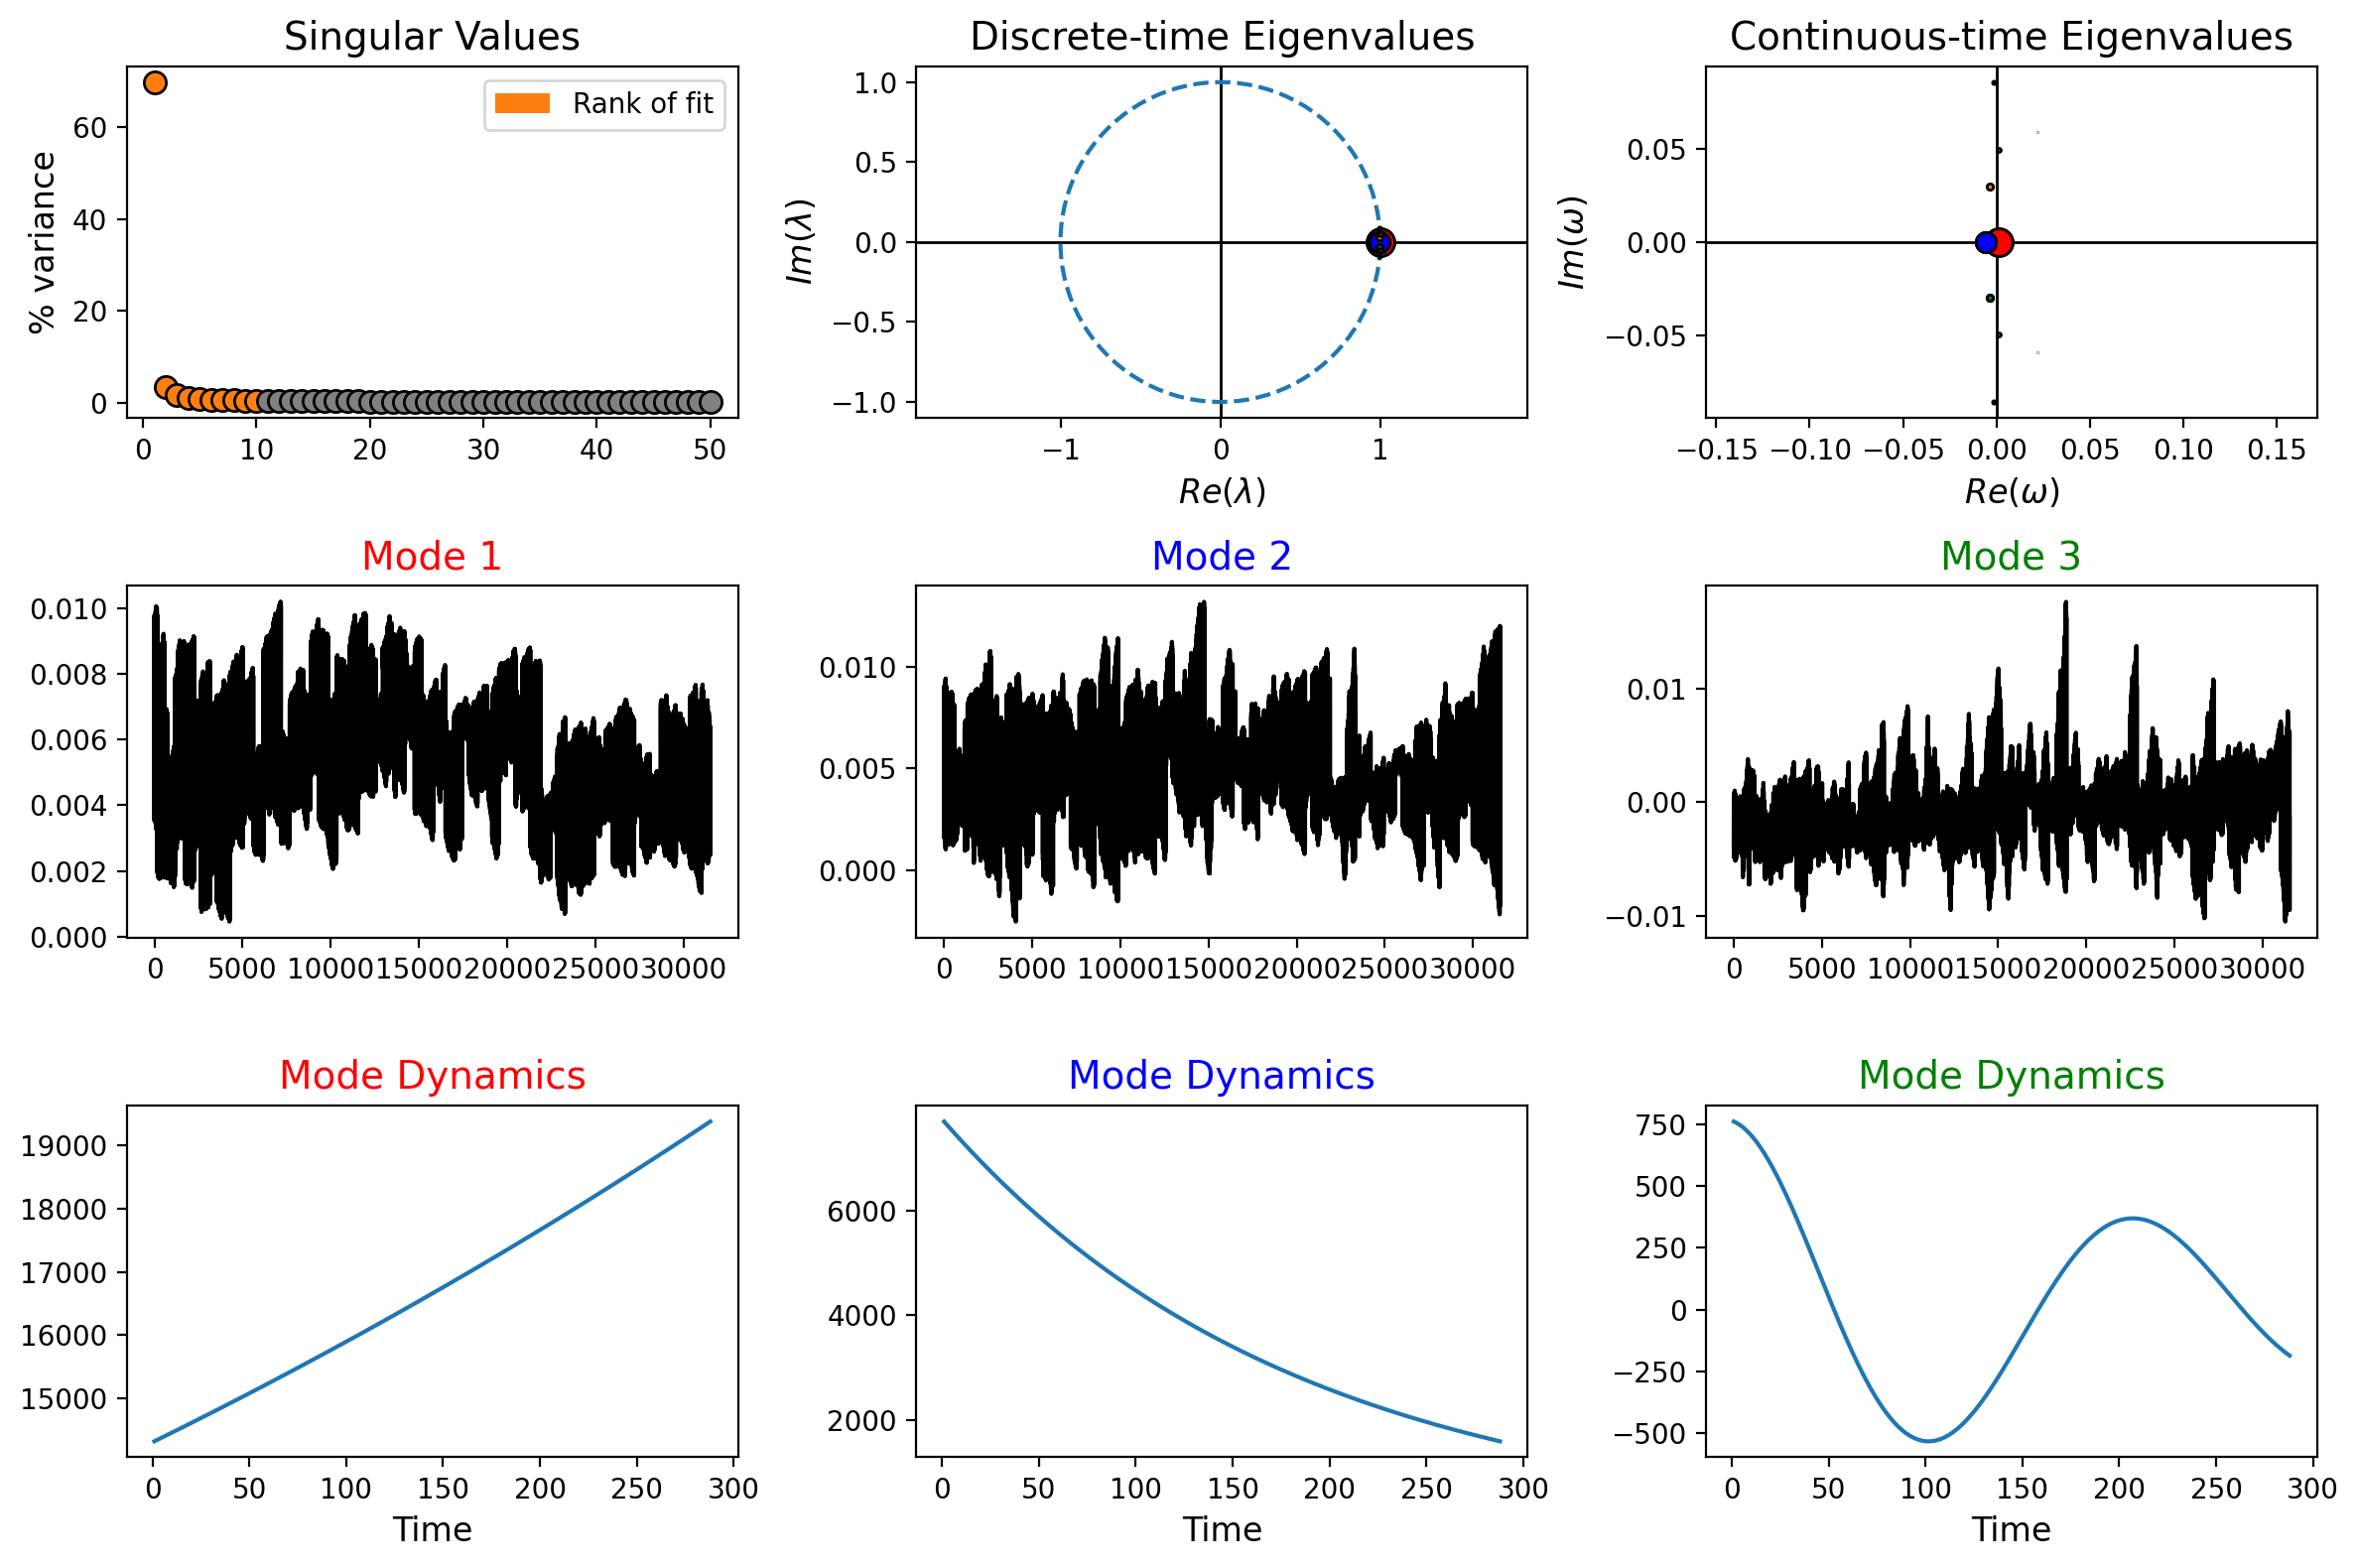

In [67]:
u = mda.Universe(fold+topology,fold+trajectory)
#Select domain
domain_group1 = u.select_atoms(selection_protein) #resid residue-number-range (inclusive)
domain_glycan = u.select_atoms(selection_glycan)
r=10
domain = domain_group1+domain_glycan
#Create trajectory matrix
nt = timesteps
X1 = np.zeros((domain.n_atoms*3,nt)) #Trajectory matrix
for nt_step in u.trajectory:
    X1[:,nt_step.frame] = np.reshape(domain.positions,-1) # [x1,y1,z1,x2,y2,z2,...] can be improved!

from pydmd import DMD, BOPDMD, EDMD
from pydmd.plotter import plot_eigs, plot_summary
%matplotlib inline

# Build the Optimized DMD model.
t = np.linspace(1,nt,nt)
optdmd = BOPDMD(svd_rank=r)#, varpro_opts_dict={"verbose": True, "tol": 0.04}) #uncomment to add options
#dmd = DMD(svd_rank=4)
optdmd.fit(X1, t)

# Plot a summary of the DMD results.
plot_summary(optdmd)

In [68]:
#create .xtc for dmd reconstructed trajectory
n_atoms = len(domain)
# Reshape X1 to [n_timesteps, n_atoms, 3]
X1_reshaped = np.real(optdmd.reconstructed_data).T.reshape(nt, n_atoms, 3)  # Transpose and reshape

rmsd_dmd = {}
rmsd = {}
dict_domain = {'group1':selection_protein, 
               'glycan':selection_glycan}
for key,value in dict_domain.items():
    domain_dmd = mda.Merge(domain).load_new(
            X1_reshaped[:, :, :], order="fac") #frame atom coordinate
    aligner = align.AlignTraj(domain_dmd, domain_dmd, select=value, in_memory=True)
    aligner.run()
    R = mda.analysis.rms.RMSD(domain_dmd, domain_dmd, select=value, ref_frame=0)              
    R.run()
    rmsd_dmd[key] = R.rmsd.T

for key,value in dict_domain.items():
    u = mda.Universe(fold+topology,fold+trajectory)
    aligner = align.AlignTraj(u, u, select=value, in_memory=True)
    aligner.run()
    R = mda.analysis.rms.RMSD(u, u, select=value, ref_frame=0)              
    R.run()
    rmsd[key] = R.rmsd.T 



c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\MDAnalysis\analysis\rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


The next steps we show some statistics from MD and the reconstructed DMD analysis

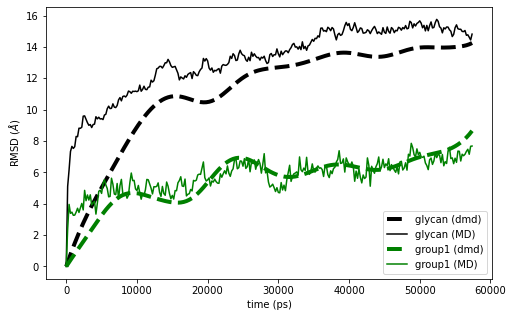

In [69]:
#Plot
fig = plt.figure(figsize=(8,5))
plt.plot(rmsd['glycan'][0]*u.coord.dt, rmsd_dmd['glycan'][2], 'k--',  label="glycan (dmd)",linewidth=4); 
plt.plot(rmsd['glycan'][1], rmsd['glycan'][2], 'k',  label="glycan (MD)");
plt.plot(rmsd['group1'][0]*u.coord.dt, rmsd_dmd['group1'][2], 'g--',  label="group1 (dmd)",linewidth=4); 
plt.plot(rmsd['group1'][1], rmsd['group1'][2], 'g',  label="group1 (MD)");
plt.legend(loc="best"); plt.xlabel("time (ps)"); plt.ylabel(r"RMSD ($\AA$)");

In [70]:
rmsf_dmd = {}
rmsf = {}
dict_domain = {'group1':selection_protein, 
               'glycan':selection_glycan}
for key,value in dict_domain.items(): #Based on MDAnalysis script
    domain_dmd = mda.Merge(domain).load_new(
            X1_reshaped[:, :, :], order="fac") #frame atom coordinate
    selection = domain_dmd.select_atoms(value)
    reference_coordinates = domain_dmd.trajectory.timeseries(asel=selection).mean(axis=1)
    reference = mda.Merge(selection).load_new(
                reference_coordinates[:, None, :], order="afc")           
    aligner = align.AlignTraj(domain_dmd, reference, select=value, in_memory=True).run()
    rmsf_dmd[key] = RMSF(selection, verbose=True).run()

for key,value in dict_domain.items(): #Based on MDAnalysis script
    u = mda.Universe(fold+topology,fold+trajectory, in_memory=True)
    selection = u.select_atoms(value)
    reference_coordinates = u.trajectory.timeseries(asel=selection).mean(axis=1)
    reference = mda.Merge(selection).load_new(
                reference_coordinates[:, None, :], order="afc")           
    aligner = align.AlignTraj(u, reference, select=value, in_memory=True).run()
    rmsf[key] = RMSF(selection, verbose=True).run()

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

c:\Users\ianad\anaconda3\envs\bempp\lib\site-packages\MDAnalysis\analysis\rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0.5, 1.0, 'Glycan (MD)')

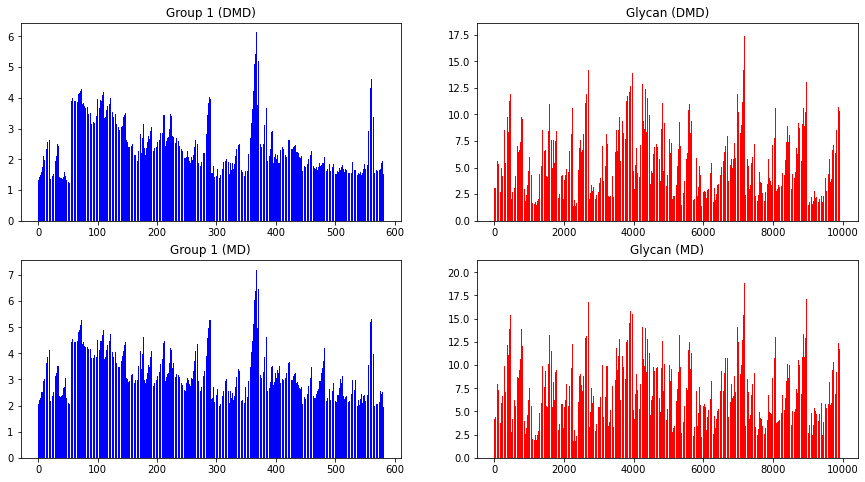

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs[0,0].bar(range(len(domain_dmd.select_atoms(dict_domain['group1']))), rmsf_dmd['group1'].rmsf,color='b')
axs[0,1].bar(range(len(domain_dmd.select_atoms(dict_domain['glycan']))), rmsf_dmd['glycan'].rmsf,color='r')
axs[1,0].bar(range(len(domain.select_atoms(dict_domain['group1']))), rmsf['group1'].rmsf,color='b')
axs[1,1].bar(range(len(domain.select_atoms(dict_domain['glycan']))), rmsf['glycan'].rmsf,color='r')

axs[0, 0].set_title('Group 1 (DMD)'); axs[0, 1].set_title('Glycan (DMD)')
axs[1, 0].set_title('Group 1 (MD)'); axs[1, 1].set_title('Glycan (MD)')

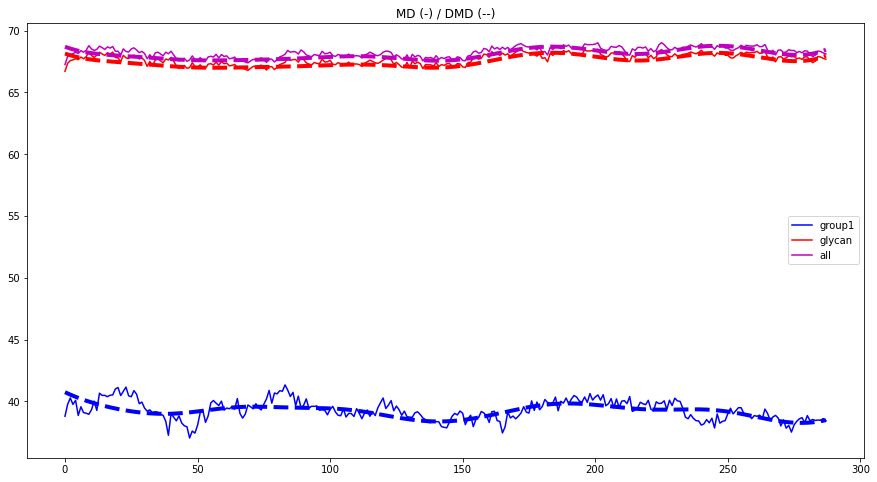

In [72]:
rog_dmd = {'group1':[],'glycan':[],'all':[]}
rog = {'group1':[],'glycan':[],'all':[]}
dict_domain = {'group1':selection_protein, 
               'glycan':selection_glycan,
               'all': f'{selection_protein} or {selection_glycan}'}
for key,value in dict_domain.items(): #Based on MDAnalysis script
    group_dmd = domain_dmd.select_atoms(value)
    group = u.select_atoms(value)
    for ntime in domain_dmd.trajectory:
        rog_dmd[key].append(group_dmd.atoms.radius_of_gyration())
    for ntime in u.trajectory:
        rog[key].append(group.atoms.radius_of_gyration())
    rog_dmd[key] = np.array(rog_dmd[key])
    rog[key] = np.array(rog[key])

fig, axs = plt.subplots(1, 1, figsize=(15,8))
axs.plot(range(len(rog['group1'])), rog['group1'],color='b',label='group1')
axs.plot(range(len(rog['glycan'])), rog['glycan'],color='r',label='glycan')
axs.plot(range(len(rog['all'])), rog['all'],color='m',label='all')
axs.plot(range(len(rog_dmd['group1'])), rog_dmd['group1'],color='b',linestyle='--',linewidth=4)
axs.plot(range(len(rog_dmd['glycan'])), rog_dmd['glycan'],color='r',linestyle='--',linewidth=4)
axs.plot(range(len(rog_dmd['all'])), rog_dmd['all'],color='m',linestyle='--',linewidth=4)

axs.legend(); 
axs.set_title('MD (-) / DMD (--)'); 

Text(0.5, 0.98, 'Timestep -1')

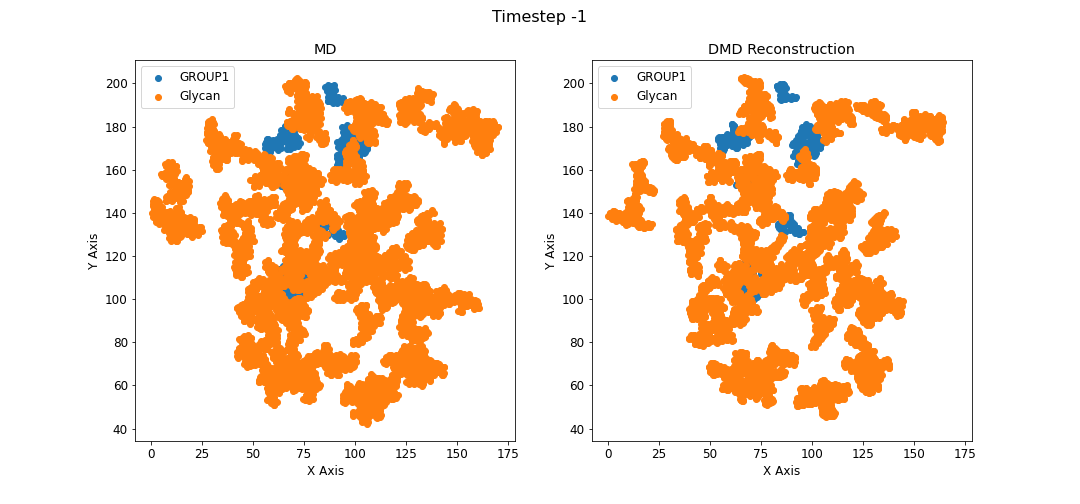

In [74]:
timestep = -1
nt = timesteps
%matplotlib widget
X_traj_dmd = optdmd.reconstructed_data.reshape(len(domain),3,nt)
X_traj = X1.reshape(len(domain),3,nt) 
len_cut1 = len(domain_group1)
rcParams['font.size'] = 12
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))
ax1.scatter(np.real(X_traj[:len_cut1,0,timestep]),np.real(X_traj[:len_cut1,1,timestep]),label='GROUP1')
ax1.scatter(np.real(X_traj[len_cut1+1:,0,timestep]),np.real(X_traj[len_cut1+1:,1,timestep]),label='Glycan')
ax1.set_title('MD'); ax1.set_xlabel('X Axis'); ax1.set_ylabel('Y Axis'); ax1.legend()

ax2.scatter(np.real(X_traj_dmd[:len_cut1,0,timestep]),np.real(X_traj_dmd[:len_cut1,1,timestep]),label='GROUP1')
ax2.scatter(np.real(X_traj_dmd[len_cut1+1:,0,timestep]),np.real(X_traj_dmd[len_cut1+1:,1,timestep]),label='Glycan')
ax2.set_title('DMD Reconstruction'); ax2.set_xlabel('X Axis'); ax2.set_ylabel('Y Axis')
ax2.legend(); ax2.set_xlim(ax1.get_xlim()); ax2.set_ylim(ax1.get_ylim())

fig.suptitle(f'Timestep {timestep}', fontsize=16)
